# Processamento de Imagens de Satélite para Geração de Máscaras de Uso e Ocupação do Solo

Este notebook processa imagens de satélite do CBERS 04A, que possuem dimensões de aproximadamente 56074 x 57614 pixels. Para facilitar a manipulação, as imagens são cortadas em patches menores de 3840 x 3840 pixels.

Em seguida, utilizamos dados de polígonos de edificações do Open Buildings V3 Polygons para criar máscaras binárias que indicam a presença de construções nas imagens de satélite. O georreferenciamento assegura o alinhamento preciso entre as imagens e os polígonos.

Este processo gera um conjunto de dados preparado para análises de uso do solo e treinamentos de modelos de segmentação.

## Criar patchs nas imagens originais do CBERS

O satélite [CBERS 04A](http://www.cbers.inpe.br/lancamentos/cbers04a.php), parte do programa de cooperação entre Brasil e China, foi lançado em 2019. Equipado com câmeras de alta resolução, ele oferece imagens detalhadas para monitoramento ambiental, agrícola e urbano. O download das imagens pode ser feito através do [site](http://queimadas.dgi.inpe.br/catalogo/explore) do Instituto Nacional de Pesquisas Espaciais.

As imagens são disponibilizadas com as bandas RGB e PAN desassociadas, dessa forma, após a composição de bandas para obtenção da imagem em cores naturais, é obtida uma imagen de resolução de 8 metros por pixel. Em seguida, foi realizado o pansharpening para obtenção de uma nova imagem de 2 metros por pixel. Estes processos foram realizados pelo QGIS. As imagens resultantes sguem o exemplo da Figura 1, as imagens apresentam cerca de 56074 x 57614 pixels, sendo a resolução 2m/pixel.

Figura 1. Imagem de satélite do sensor CBERS 04A com cores naturais.

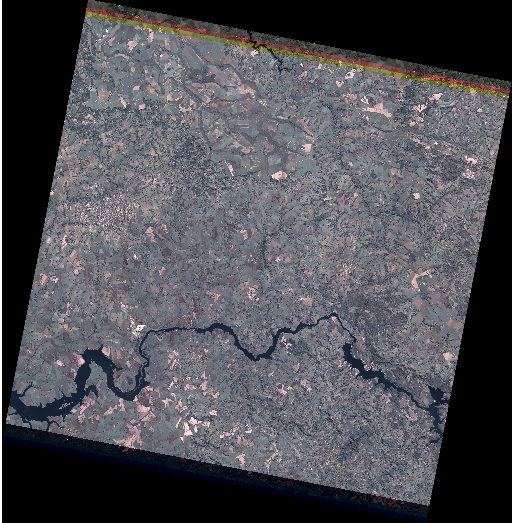

<span1 style="padding-right: 150px;"></span1>Fonte: Elaboração própria.


Então, o primeiro passo do processamento será a criação de patchs das imagens, tendo em vista que se tratam de imagens de dimensões muito grandes e o seu processamento e armazenamento pode apresentar alto custo computacional.

In [2]:
import os
import numpy as np
from PIL import Image
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine

In [2]:
# Função para verificar se o patch contém bordas pretas
def contains_black_borders(patch, threshold=10):
    gray_patch = patch.convert('L')
    np_patch = np.array(gray_patch)
    return np.any(np_patch[:threshold, :] == 0) or np.any(np_patch[-threshold:, :] == 0) or \
           np.any(np_patch[:, :threshold] == 0) or np.any(np_patch[:, -threshold:] == 0)

# Função para recortar um patch mantendo a georreferência
def recortar_patch(src, output_path, x_off, y_off, width, height):
    try:
        # Definir a janela de leitura
        window = Window(x_off, y_off, width, height)
        
        # Ler os dados da janela especificada
        patch_data = src.read(window=window)
        
        # Atualizar a transformação afim para o patch recortado
        transform = src.window_transform(window)
        
        # Metadados para o arquivo de saída
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": height,
            "width": width,
            "transform": transform,
            "compress": "lzw"  # Opcional: compressão para reduzir o tamanho do arquivo
        })
        
        # Verificar se o patch contém bordas pretas
        patch_image = Image.fromarray(patch_data.transpose(1, 2, 0))  # Converter para imagem PIL
        if not contains_black_borders(patch_image):
            # Escrever a imagem de saída
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(patch_data)
                
    except rasterio.errors.RasterioIOError as e:
        print(f"Erro ao escrever o patch no arquivo {output_path}: {e}")
    except Exception as e:
        print(f"Erro inesperado ao processar o patch no arquivo {output_path}: {e}")

# Função para processar todas as imagens em um diretório
def process_images(input_directory, output_directory, patch_size):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for file_name in os.listdir(input_directory):
        if file_name.endswith('.tif'):
            input_path = os.path.join(input_directory, file_name)
            with rasterio.open(input_path) as src:
                width = src.width
                height = src.height
                
                patch_count = 0
                for i in range(0, width, patch_size):
                    for j in range(0, height, patch_size):
                        output_path = os.path.join(output_directory, f'{os.path.splitext(file_name)[0]}_patch_{patch_count}.tif')
                        recortar_patch(src, output_path, i, j, patch_size, patch_size)
                        patch_count += 1

In [4]:

# Diretórios de entrada e saída
input_directory = '/home/luisa/Documentos/CBERS/images/composicao'
output_directory = '/home/luisa/Documentos/CBERS/images/IMAGES'
patch_size = 3840 # tamanho escolhido para os patchs

# Processar todas as imagens no diretório de entrada
process_images(input_directory, output_directory, patch_size)

print(f'Patches salvos no diretório {output_directory}')


Patches salvos no diretório /home/luisa/Documentos/CBERS/images/IMAGES


# Varrer arquivo do Open Buildings V3 Polygons e criar máscara binária das imagens do CBERS

O [Open Buildings V3 Polygons](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_Research_open-buildings_v3_polygons) é um conjunto de dados geoespaciais criado pelo Google, que fornece polígonos detalhados de edificações em todo o mundo. Utilizando técnicas avançadas de aprendizado de máquina, ele mapeia com precisão as áreas construídas, facilitando análises urbanas, planejamento territorial e estudos sobre ocupação do solo em grande escala.

Para gerar máscaras binárias das imagens do CBERS, é necessário realizar a correspondência entre as imagens e os dados de polígonos. Uma abordagem comum é utilizar técnicas de classificação supervisionada, como o aprendizado de maquina (ML) com dados de treinamento que contêm as áreas construídas.
 Abaixo, na Figura 2 podemos ver um exemplo de imagem de satélite e sua máscara correspondente;


<span1 style="padding-right: 350px;"></span1>Figura 2. Imagem de satélite e máscara correspondente.

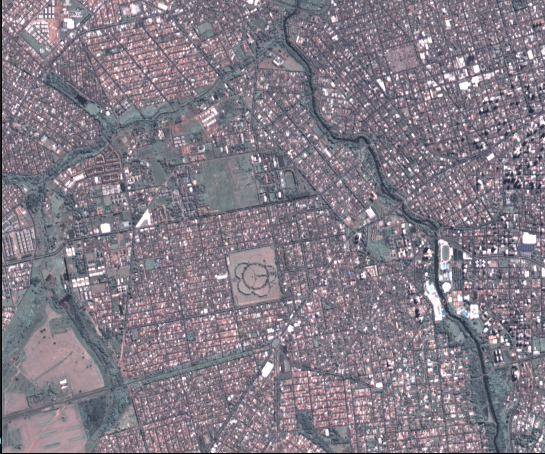  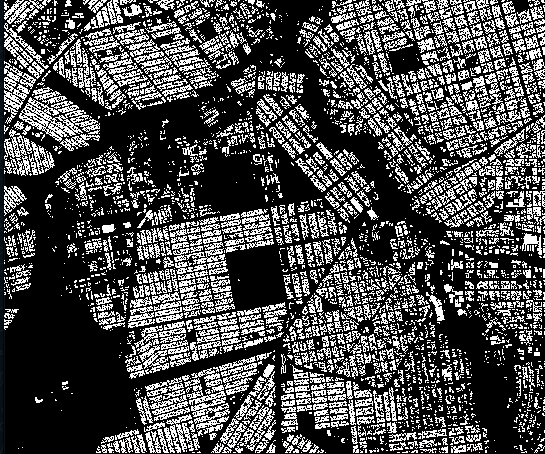

<span1 style="padding-right: 220px;"></span1>Imagem RGB<span2 style="padding-right: 450px;"> </span2>Máscara Binária


O alinhamento entre as imagens de satélite e os dados de polígonos é garantido através do georreferenciamento, permitindo a correspondência precisa entre as coordenadas das imagens e as dos polígonos. O script a seguir realiza o alinhamento e gera as máscaras.

In [3]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import box
from rasterio.features import rasterize
import glob
import shutil

In [3]:
cont = 0 # modificar o cont após trocar o csv_file do tile do open buildings 

# Caminho para o arquivo CSV
csv_file = '/home/luisa/Documentos/CBERS/masks_opb/935_buildings.csv'
input_folder = '/home/luisa/Documentos/CBERS/images/IMAGES/'
output_folder = '/home/luisa/Documentos/CBERS/masks/'
move_folder = '/home/luisa/Documentos/CBERS/images/processed/'

# Leia o CSV 
df = pd.read_csv(csv_file)

# Converta a coluna de geometria de WKT para geometria shapely, se necessário
if df['geometry'].dtype == 'object':
    df['geometry'] = df['geometry'].apply(shapely.wkt.loads)

# Converta o DataFrame para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Defina o CRS (sistema de referência de coordenadas), aqui assumindo WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Função para criar a máscara raster
def create_mask(gdf, image_shape, image_transform):
    shapes = ((geom, 1) for geom in gdf.geometry if not geom.is_empty)
    mask = rasterize(
        shapes,
        out_shape=image_shape,
        transform=image_transform,
        fill=0,
        dtype=np.uint8
    )
    # Binarizar a máscara (valores 0 ou 1)
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,-12.064738,-45.794916,65.4287,0.6936,"POLYGON ((-45.79488 -12.06478, -45.79489 -12.0...",58VPW6P4+424G
1,-16.870033,-47.440069,44.7300,0.7726,"POLYGON ((-47.44003 -16.87005, -47.44004 -16.8...",58MJ4HH5+XXMQ
2,-16.693990,-46.698536,29.3510,0.7818,"POLYGON ((-46.69851 -16.69401, -46.69852 -16.6...",58MM8842+CH4H
3,-14.262361,-49.655624,22.8167,0.6719,"POLYGON ((-49.65560 -14.26238, -49.65560 -14.2...",58QGP8QV+3Q2C
4,-16.648186,-49.323624,102.8389,0.8139,"POLYGON ((-49.32359 -16.64824, -49.32358 -16.6...",58MG9M2G+PHCC
...,...,...,...,...,...,...
6298428,-15.765931,-48.288306,96.6691,0.8626,"POLYGON ((-48.28824 -15.76593, -48.28831 -15.7...",58PH6PM6+JMGJ
6298429,-16.105082,-47.920921,26.6928,0.7416,"POLYGON ((-47.92089 -16.10507, -47.92093 -16.1...",58MJV3VH+XJ8P
6298430,-15.650313,-47.805847,61.2751,0.8559,"POLYGON ((-47.80579 -15.65030, -47.80590 -15.6...",58PJ85XV+VMCH
6298431,-15.946604,-48.255884,22.5638,0.7030,"POLYGON ((-48.25587 -15.94657, -48.25589 -15.9...",58PH3P3V+9J5W


In [ ]:
# Iterar sobre todos os arquivos TIFF na pasta de entrada
for input_tif in glob.glob(os.path.join(input_folder, '*.tif')):
    with rasterio.open(input_tif) as src:
        image_bounds = src.bounds
        image_transform = src.transform
        image_crs = src.crs
        image_shape = src.shape

        # Crie um polígono a partir dos limites da imagem
        image_polygon = box(image_bounds.left, image_bounds.bottom, image_bounds.right, image_bounds.top)

        # Converta o GeoDataFrame para o mesmo CRS da imagem
        gdf = gdf.to_crs(image_crs)

        # Filtre os polígonos que estão dentro da área da imagem TIFF
        gdf_filtered = gdf[gdf.intersects(image_polygon)]

        # Verifique se há geometrias válidas após a filtragem
        if gdf_filtered.empty:
            print(f"Nenhum polígono encontrado dentro dos limites da imagem TIFF {input_tif}.")
            continue

        # Crie a máscara raster
        mask = create_mask(gdf_filtered, image_shape, image_transform)
        # Converta a máscara para uma imagem PIL e aplique 'L' (grayscale)
        mask_image = Image.fromarray(mask * 255).convert('L')
        # Converta a imagem de volta para um array numpy
        mask = np.array(mask_image)

        # Verifique se a máscara contém valores não nulos
        if np.any(mask):
            # Nome do arquivo de saída
            output_mask_tif = os.path.join(output_folder, os.path.basename(input_tif).replace('.tif', '_mask.tif'))

            # Defina o perfil do raster para a máscara
            profile = src.profile
            profile.update(
                dtype=rasterio.uint8,
                count=1,
                compress='lzw'
            )

            # Salve a máscara raster em um novo arquivo TIFF
            with rasterio.open(output_mask_tif, 'w', **profile) as dst:
                dst.write(mask, 1)
                cont = cont + 1

            print(f"Máscara raster salva em {output_mask_tif}")

            # Mova a imagem original para a pasta de imagens processadas
            shutil.move(input_tif, os.path.join(move_folder, os.path.basename(input_tif)))
            print(f"Imagem original movida para {move_folder}")
        else:
            print(f"Nenhum valor não nulo na máscara para a imagem {input_tif}.")

### Junção de dois tiles para criar máscara

Existem casos onde uma imagem do satélite está presente em mais de um tile do open buildings.

In [3]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import box
import rasterio
from rasterio.features import rasterize
import numpy as np
from PIL import Image
import shutil
import os

# Caminho para os arquivos CSV
csv_files = [
    '/home/luisa/Documentos/CBERS/masks_opb/00b_buildings2.csv',
    '/home/luisa/Documentos/CBERS/masks_opb/075_buildings.csv'  # Adicione o segundo arquivo CSV aqui
]

input_tif = '/home/luisa/Documentos/INTEGRA_M4/IMAGE_TEST_M4/CBERS/CBERS_4A_WPM_20200622_198_140_L4_B0.tif'
output_mask_tif = '/home/luisa/Documentos/IMAGENS_MACRO_4/imagens de teste/CBERS/mask.tif'
move_folder = '/home/luisa/Documentos/IMAGENS_MACRO_4/imagens de teste/CBERS/'

# Função para ler e converter CSV em GeoDataFrame
def read_and_convert_csv(csv_file):
    df = pd.read_csv(csv_file)
    if df['geometry'].dtype == 'object':
        df['geometry'] = df['geometry'].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    return gdf

# Combine os dados dos dois arquivos CSV em um único GeoDataFrame
gdf_list = [read_and_convert_csv(csv_file) for csv_file in csv_files]
combined_gdf = pd.concat(gdf_list, ignore_index=True)
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')

# Leia a imagem TIFF georreferenciada
with rasterio.open(input_tif) as src:
    image_bounds = src.bounds
    image_transform = src.transform
    image_crs = src.crs
    image_shape = src.shape

    # Crie um polígono a partir dos limites da imagem
    image_polygon = box(image_bounds.left, image_bounds.bottom, image_bounds.right, image_bounds.top)

    # Converta o GeoDataFrame combinado para o mesmo CRS da imagem
    combined_gdf = combined_gdf.to_crs(image_crs)

    # Filtre os polígonos que estão dentro da área da imagem TIFF
    gdf_filtered = combined_gdf[combined_gdf.intersects(image_polygon)]

    # Verifique se há geometrias válidas após a filtragem
    if gdf_filtered.empty:
        raise ValueError("Nenhum polígono encontrado dentro dos limites da imagem TIFF.")

    # Função para gerar a máscara raster
    def create_mask(gdf, image_shape, image_transform):
        shapes = ((geom, 1) for geom in gdf.geometry if not geom.is_empty)
        mask = rasterize(
            shapes,
            out_shape=image_shape,
            transform=image_transform,
            fill=0,
            dtype=np.uint8
        )
        # Binarizar a máscara (valores 0 ou 1)
        mask = np.where(mask > 0, 1, 0).astype(np.uint8)
        return mask

    # Crie a máscara raster
    mask = create_mask(gdf_filtered, image_shape, image_transform)

    # Converta a máscara para uma imagem PIL e aplique 'L' (grayscale)
    mask_image = Image.fromarray(mask * 255).convert('L')

    # Converta a imagem de volta para um array numpy
    mask = np.array(mask_image)

    # Defina o perfil do raster para a máscara
    profile = src.profile
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw'
    )

# Salve a máscara raster em um novo arquivo TIFF
with rasterio.open(output_mask_tif, 'w', **profile) as dst:
    dst.write(mask, 1)

print(f"Máscara raster salva em {output_mask_tif}")
#shutil.move(input_tif, os.path.join(move_folder, os.path.basename(input_tif)))
#print(f"Imagem original movida para {move_folder}")


Máscara raster salva em /home/luisa/Documentos/IMAGENS_MACRO_4/imagens de teste/CBERS/mask.tif
